In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import pycountry
import seaborn as sns

data_2021_2023 = pd.read_csv('Data/salaries.csv')
data_2017_2020 = pd.read_csv('Data/2019_Data_Professional_Salary_Survey_Responses.csv')

#  Data Cleaning

#### Copy of dataframe

In [26]:
data_2017_2020_copy = data_2017_2020.copy()
data_2021_2023_copy = data_2021_2023.copy()

#### Delete columns

In [27]:
data_2021_2023_copy = data_2021_2023_copy\
    .drop(["company_size", "remote_ratio", "salary_currency", "company_size", "salary"], axis=1)

In [28]:
data_2017_2020_copy = data_2017_2020_copy.drop(['Timestamp', 'PostalCode',
                                                'PrimaryDatabase', 'YearsWithThisDatabase', 'OtherDatabases',
                                                'ManageStaff', 'YearsWithThisTypeOfJob',
                                                'HowManyCompanies', 'OtherPeopleOnYourTeam', 'CompanyEmployeesOverall',
                                                'DatabaseServers', 'Education', 'EducationIsComputerRelated',
                                                'Certifications', 'HoursWorkedPerWeek', 'TelecommuteDaysPerWeek',
                                                'PopulationOfLargestCityWithin20Miles',
                                                'LookingForAnotherJob', 'CareerPlansThisYear', 'Gender',
                                                'OtherJobDuties', 'KindsOfTasksPerformed', 'Counter',
                                                'EmploymentSector'], axis=1)

#### Rename columns

In [29]:
data_2017_2020_copy.loc[:, 'EmploymentStatus'] = data_2017_2020_copy['EmploymentStatus']\
    .replace('Full time employee','Full time')\
    .replace('Full time employee of a consulting/contracting company', 'Full time')\
    .replace('Independent or freelancer or company owner', 'Freelance')\
    .replace('Independent consultant, contractor, freelancer,  or company owner', 'Contract')

In [30]:
data_2021_2023_copy.loc[:, 'employment_type'] = data_2021_2023_copy['employment_type']\
    .replace('FT','Full time')\
    .replace('CT', 'Contract')\
    .replace('PT', 'Part time')\
    .replace('FL', 'Freelance')

#### Rename row values

In [31]:
def get_country_name(initial):
    try:
        country = pycountry.countries.get(alpha_2=initial)
        return country.name
    except AttributeError:
        return initial

In [32]:
data_2021_2023_copy['company_location'] = data_2021_2023_copy['company_location'].apply(get_country_name)
data_2021_2023_copy.rename(columns={'company_location': 'Country'}, inplace=True)
data_2021_2023_copy['employee_residence'] = data_2021_2023_copy['employee_residence'].apply(get_country_name)

In [33]:
data_2021_2023_copy['experience_level'] = data_2021_2023_copy['experience_level'] \
    .replace('EN', 'Junior') \
    .replace('MI', 'Internmediate') \
    .replace('SE', 'Expert') \
    .replace('EX', 'Director')

#### Clean rows salaryUSD values

In [84]:
import re
data_2017_2020_copy = data_2017_2020_copy.copy()
data_2017_2020_copy['SalaryUSD'] = data_2017_2020_copy['SalaryUSD'].apply(lambda x: re.sub(r'[$, ]', '', x).replace('.00', ''))

KeyError: 'SalaryUSD'

#### Convert object in int

In [35]:
data_2017_2020_copy['SalaryUSD'] = data_2017_2020_copy['SalaryUSD'].astype(int)

In [36]:
data_2017_2020_copy.loc[:, "JobTitle"] = (data_2017_2020_copy.loc[:, "JobTitle"]
                                          .replace("Engineer", "Data Engineer")\
                                          .replace("Analyst", "Data Analyst")\
                                          .replace("Architect", "Data Architect")\
                                          .replace("Manager", "Data Manager")\
                                          .replace("Developer: Business Intelligence (SSRS, PowerBI, etc)", "BI Developer"))

#### Rename columns and select job title

In [37]:
retained_values = ["Data Engineer", "BI Developer", "Data Architect", "Data Analyst", "Data Manager", "Data Scientist"]

In [38]:
data_2017_2020_copy.loc[:, 'JobTitle'] = data_2017_2020_copy.loc[:, 'JobTitle'].apply(
    lambda x: x if x in retained_values else 'Other')

In [39]:
data_2021_2023_copy.loc[:, 'job_title'] = data_2021_2023_copy.loc[:, 'job_title'].apply(
    lambda x: x if x in retained_values else 'Other')

#### Convert object in datetime

In [40]:
data_2017_2020_copy['Survey Year'] = pd.to_datetime(data_2017_2020_copy['Survey Year'], format='%Y')
data_2021_2023_copy['work_year'] = pd.to_datetime(data_2021_2023_copy['work_year'], format='%Y')

In [41]:
data_2017_2020_copy = data_2017_2020_copy.rename(
    columns={"Survey Year": "work_year", "SalaryUSD": "salary_in_usd", "EmploymentStatus": "employment_type",
             "JobTitle": "job_title"})

#### Concatenate dataframes and fill NaN values

In [42]:
data_2017_2023 = pd.concat([data_2017_2020_copy, data_2021_2023_copy], ignore_index=True)
data_2017_2023.loc[:, "experience_level"] = data_2017_2023.loc[:, "experience_level"].fillna("unknown")
data_2017_2023.loc[:, "employee_residence"] = data_2017_2023.loc[:, "employee_residence"].fillna("unknown")

# Data visualization

In [43]:
salaryUSD_full_time_2017_2023 = data_2017_2023.copy()
salaryUSD_full_time_2017_2023.loc[:, "job_title"] = salaryUSD_full_time_2017_2023.loc[:, "job_title"][salaryUSD_full_time_2017_2023.loc[:, "job_title"] != "Other"]
start_year = 2017

for i in range(0, 7):
    salaryUSD_full_time_2017_2023[f'SalaryUSD_Full_time_{start_year}'] = salaryUSD_full_time_2017_2023['salary_in_usd'][
        (salaryUSD_full_time_2017_2023['work_year'] == f'{start_year}-01-01') & (
                salaryUSD_full_time_2017_2023['employment_type'] == 'Full time')]
    start_year += 1

In [44]:
Q1 = data_2017_2023.loc[:,'salary_in_usd'].quantile(0.25)
Q3 = data_2017_2023.loc[:,'salary_in_usd'].quantile(0.75)
IQR = Q3 - Q1
data_filtre = data_2017_2023[(data_2017_2023.loc[:,'salary_in_usd'] >= Q1 - 1.5 * IQR) & (data_2017_2023.loc[:,'salary_in_usd'] <= Q3 + 1.5 * IQR)]
data_filtre = data_filtre[data_filtre.loc[:,'job_title'] != "Other"]

C:\Users\mathieuvdn\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


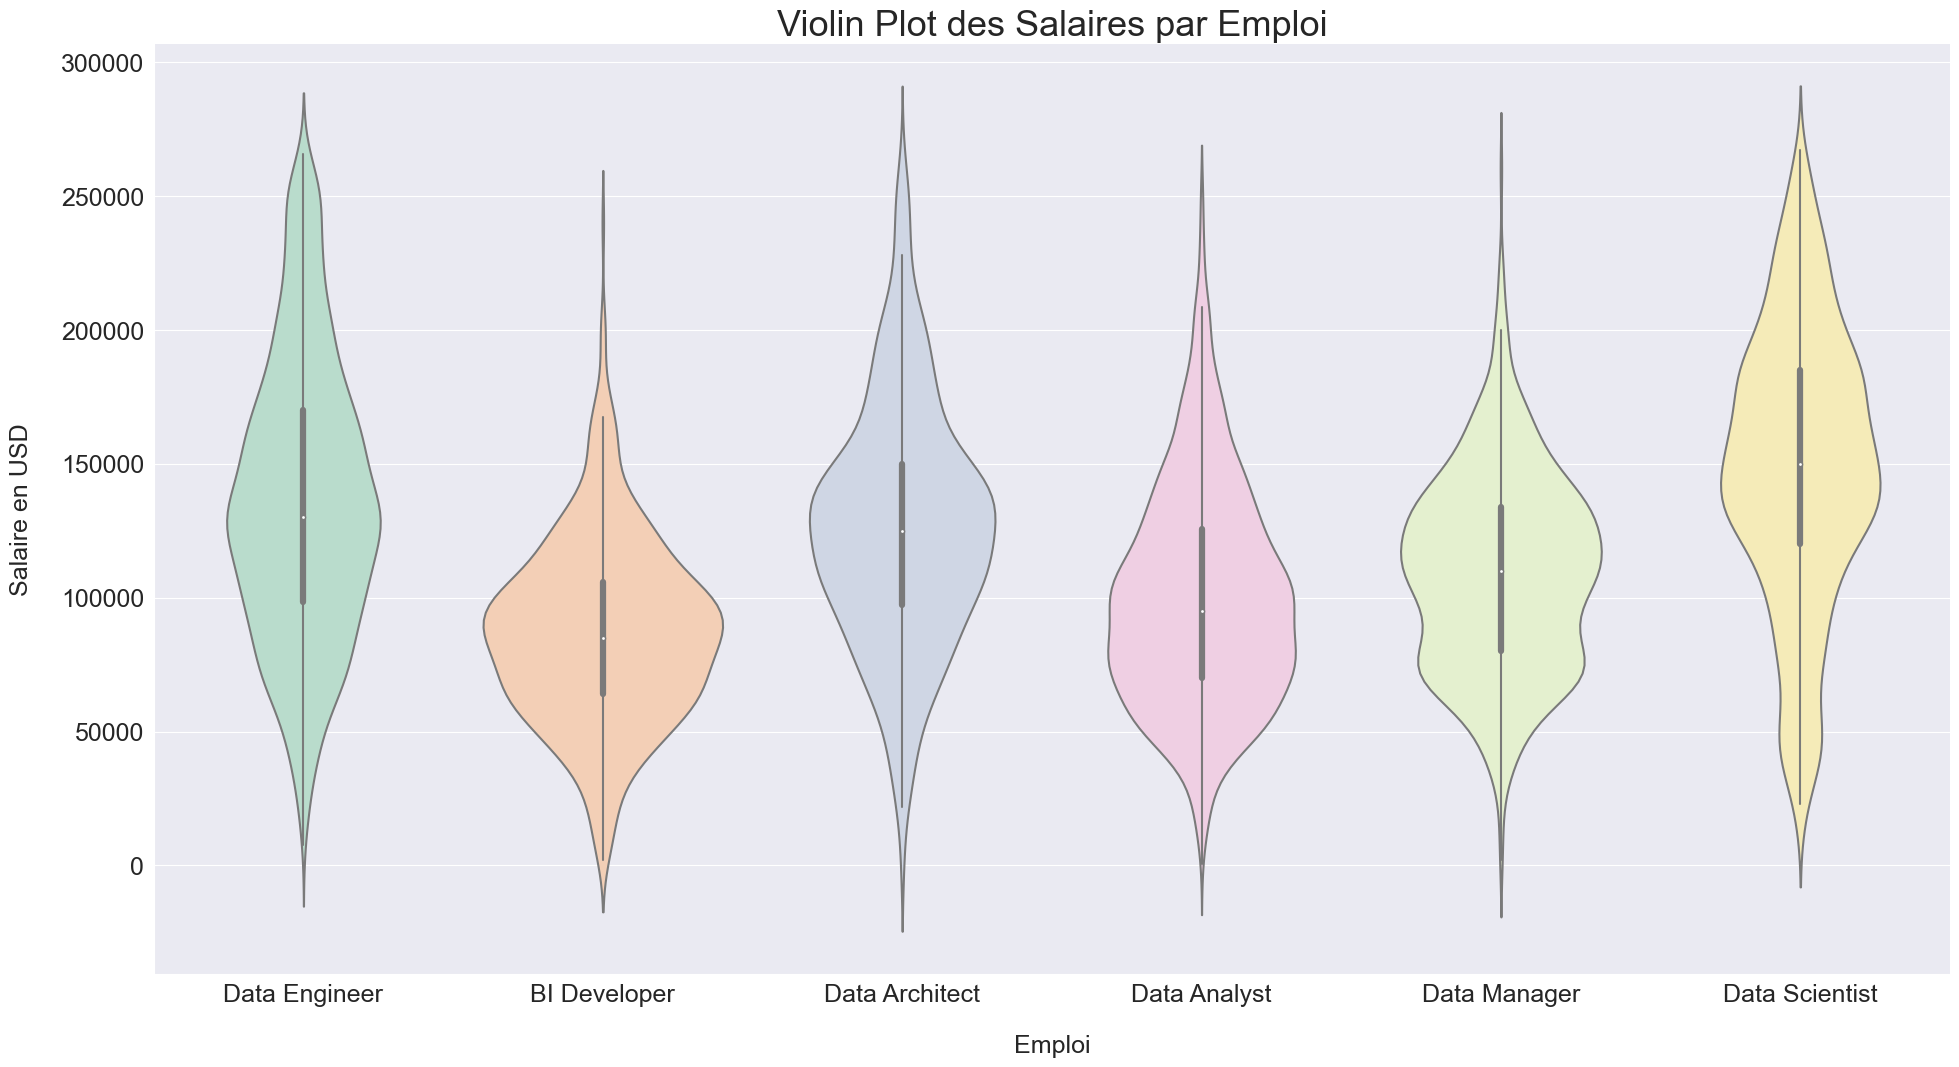

In [94]:
sns.catplot(x = "job_title", y= "salary_in_usd", palette="Pastel2",height=10, aspect=1.9,data = data_filtre, kind="violin", legend=False)
plt.xticks()
plt.ylabel('Salaire en USD', labelpad=20, fontsize = 18)
plt.xlabel('Emploi', labelpad=20, fontsize = 18)
plt.title('Violin Plot des Salaires par Emploi', fontsize=26)
plt.xticks( fontsize = 18)
plt.yticks( fontsize = 18)
plt.savefig("Violin_plot.png", format='png', bbox_inches="tight")
plt.show()


C:\Users\mathieuvdn\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


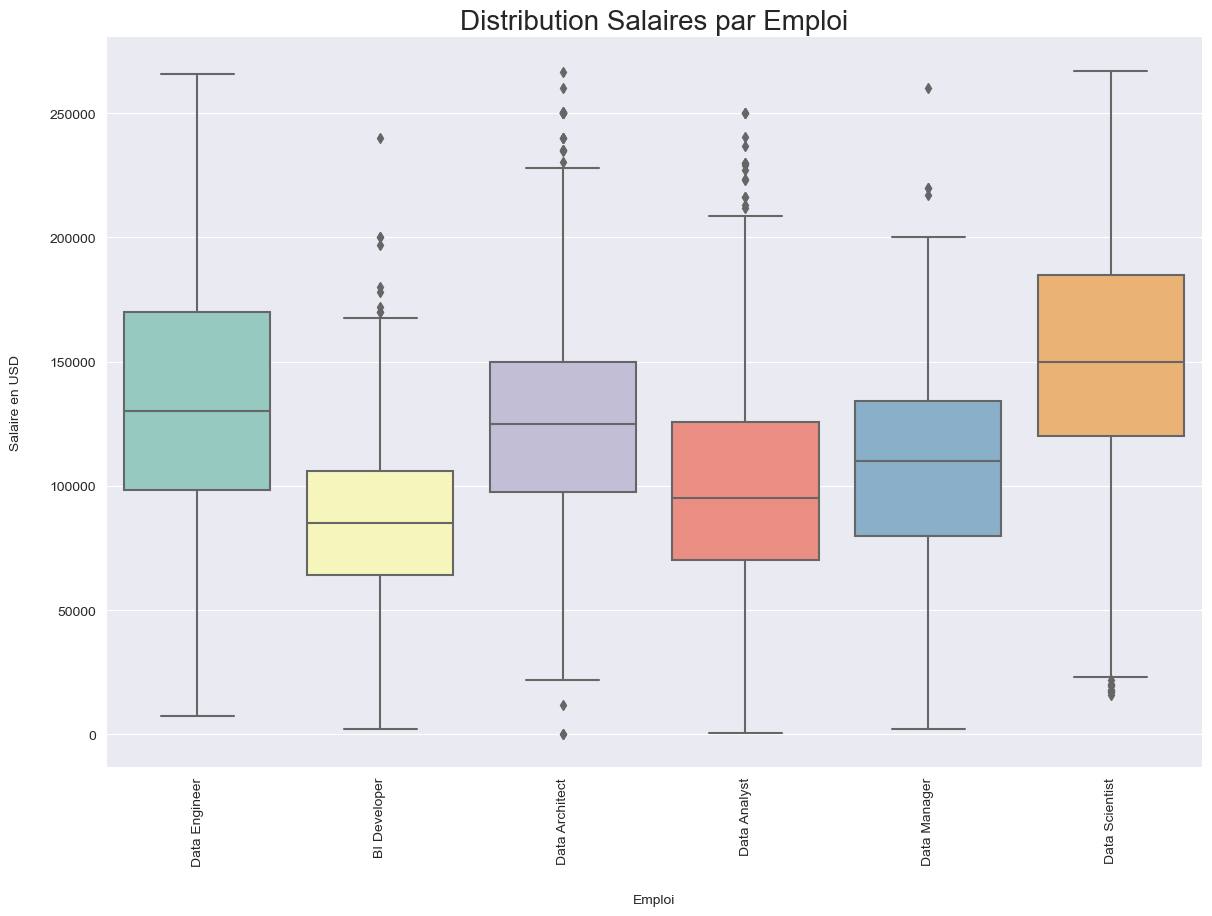

In [57]:
sns.catplot(x ="job_title" ,y= "salary_in_usd", palette="Set3",height=8, aspect=1.5,data = data_filtre, kind="box", legend=False)
plt.xticks(rotation=90)
plt.ylabel('Salaire en USD', labelpad=20)
plt.xlabel('Emploi', labelpad=20)
plt.xticks(rotation=90)
plt.title('Distribution Salaires par Emploi', fontsize=20)

plt.show()

In [72]:
years = range(2017, 2024)
salaryUSD_full_time_2017_2023 = data_2017_2023.copy()

for year in years:
    column_name = f'SalaryUSD_Full_time_{year}'
    condition = (salaryUSD_full_time_2017_2023['employment_type'] == 'Full time') & (salaryUSD_full_time_2017_2023['work_year'] == f'{year}-01-01')
    salaryUSD_full_time_2017_2023[column_name] = salaryUSD_full_time_2017_2023['salary_in_usd'][condition]


# average Salary by job title
status_2017 = salaryUSD_full_time_2017_2023.pivot_table(values=['SalaryUSD_Full_time_2017'], index=['job_title'], aggfunc='mean')
status_2018 = salaryUSD_full_time_2017_2023.pivot_table(values=['SalaryUSD_Full_time_2018'], index=['job_title'], aggfunc='mean')
status_2019 = salaryUSD_full_time_2017_2023.pivot_table(values=['SalaryUSD_Full_time_2019'], index=['job_title'], aggfunc='mean')
status_2020 = salaryUSD_full_time_2017_2023.pivot_table(values=['SalaryUSD_Full_time_2020'], index=['job_title'], aggfunc='mean')
status_2021 = salaryUSD_full_time_2017_2023.pivot_table(values=['SalaryUSD_Full_time_2021'], index=['job_title'], aggfunc='mean')
status_2022 = salaryUSD_full_time_2017_2023.pivot_table(values=['SalaryUSD_Full_time_2022'], index=['job_title'], aggfunc='mean')
status_2023 = salaryUSD_full_time_2017_2023.pivot_table(values=['SalaryUSD_Full_time_2023'], index=['job_title'], aggfunc='mean')

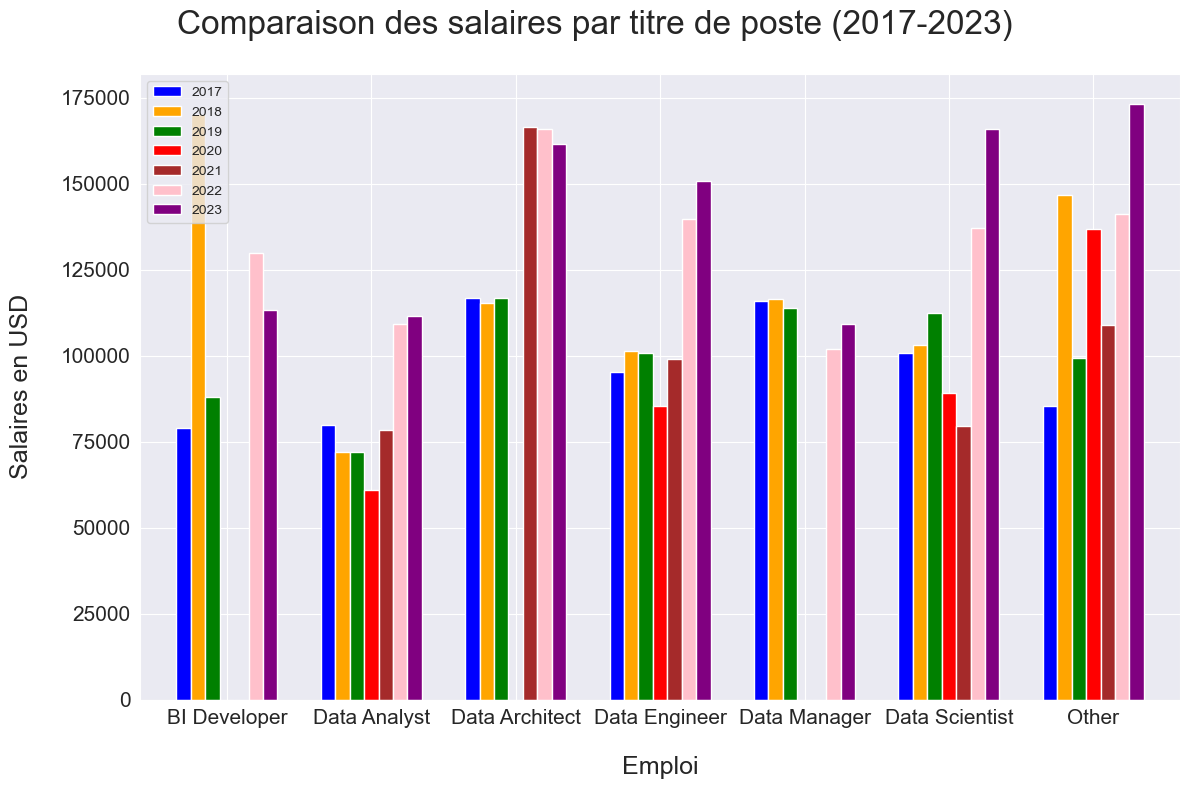

In [100]:
combined_data = pd.concat([status_2017, status_2018, status_2019, status_2020, status_2021, status_2022, status_2023], axis=1)

fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle('Comparaison des salaires par titre de poste (2017-2023)', fontsize = 24)

colors = ['blue', 'orange', 'green', 'red', 'brown', 'pink', 'purple']

combined_data.plot(kind='bar', ax=ax, legend=True, color=colors,  width=0.7)
plt.ylabel('Salaires en USD', labelpad=20, fontsize=18)
plt.xlabel('Emploi', labelpad=20,  fontsize=18)

plt.xticks(rotation=0, fontsize =15)
plt.yticks(rotation=0, fontsize =15)
plt.legend([2017,2018,2019, 2020, 2021, 2022, 2023])
plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.4)
plt.savefig("bar_plot.png", format='png', bbox_inches="tight")
plt.show()

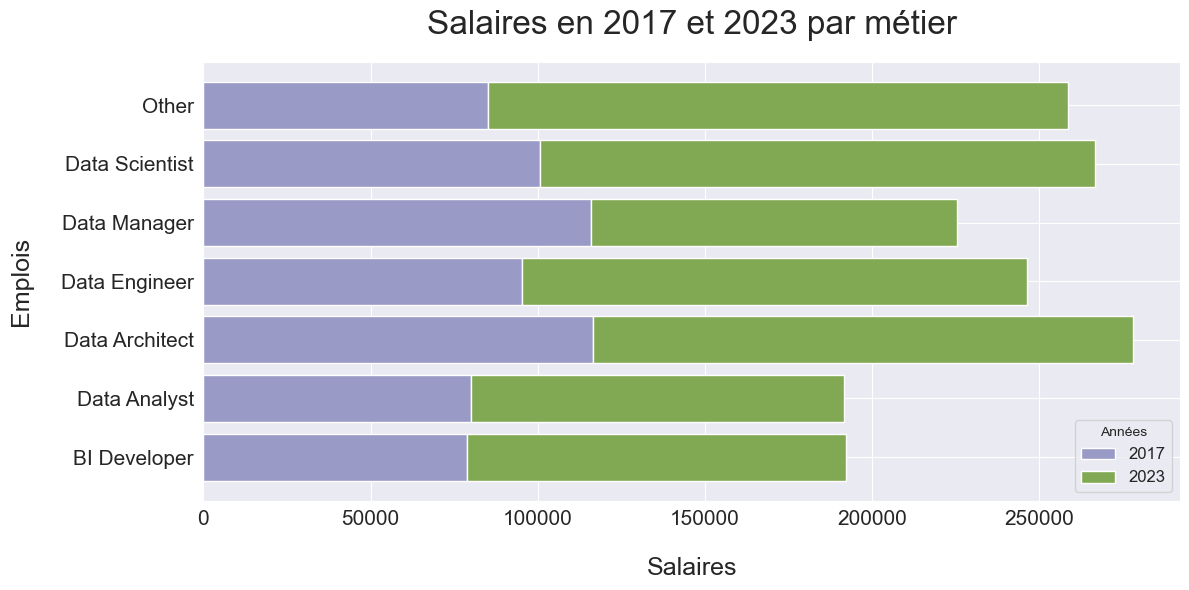

In [108]:
pivot_table = salaryUSD_full_time_2017_2023.pivot_table(values=["SalaryUSD_Full_time_2017", "SalaryUSD_Full_time_2023"], index=['job_title'], aggfunc='mean').astype(int)

# Extraire les données pour les salaires de 2017 et 2023
salaires_2017 = pivot_table["SalaryUSD_Full_time_2017"]
salaires_2023 = pivot_table["SalaryUSD_Full_time_2023"]

# Créer un nuage de points horizontal avec des couleurs différentes pour chaque année
plt.figure(figsize=(12, 6))
plt.barh(pivot_table.index, salaires_2017, color='#999AC6', label='2017')
plt.barh(pivot_table.index, salaires_2023, color='#81A953', label='2023', left=salaires_2017)

# Configurer l'axe x avec l'échelle des salaires
plt.ylabel('Emplois', fontsize =18, labelpad=20)
plt.xlabel('Salaires', fontsize =18, labelpad=20)
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)

plt.title('Salaires en 2017 et 2023 par métier', fontsize = 24, pad=20)
plt.legend(fontsize = 12, title ="Années")

plt.savefig("bar_stacked_plot.png", format='png', bbox_inches="tight")
# Afficher le nuage de points horizontal
plt.tight_layout()
plt.show()

#### Export data to csv and for power bi

In [59]:
data_2017_2023.to_csv("Salary_2017_2023.csv")

In [60]:
pivot_table = salaryUSD_full_time_2017_2023.pivot_table(values=["SalaryUSD_Full_time_2017", "SalaryUSD_Full_time_2023"], index=['job_title'], aggfunc='mean')
pivot_table["rate"] = round(abs(((pivot_table["SalaryUSD_Full_time_2017"] - pivot_table["SalaryUSD_Full_time_2023" ])/ pivot_table["SalaryUSD_Full_time_2023"]) * 100))
pivot_table.to_csv("rate_salary.csv")